**Anexo III. Estudio de parámetros óptimos **

**José Pedro Manzano**

**Lenguaje: Python**



En este notebook se va a representar el código necesario para estudiar algunos de los parámetros más importantes a la hora de construir un grafo:
    - ¿Construir una red binaria o ponderada?
    - ¿Qué umbral utilizar si la hacemos binaria?
    - ¿A partir de qué métrica podemos definir los enlaces?
    - Algunas métricas proporcionan medidas con signo negativo. ¿Tienen sentido?
    - Para el estudio dinámico, se recomienda utilizar la técnica de sliding-window. ¿Cuál es el tamaño de ventana y solapamiento adecuado?

Los comentarios hacen alusión al código y a algunos de los resultados; para conocer los principios teóricos o la motivación de este trabajo se debe acudir a la memoria.

*NOTA: Exceptuando los apartados donde se estudie un parámetro en concreto, la configuración general será la estándar: Matrices de conectividad ponderadas construidas a partir de correlación lineal de Pearson y del promediado de sujetos (en lugar de hacerlo con un solo individuo, que es mucho más variable), sin realizar valor absoluto ni transformación de los coeficientes de correlación.*

**Setup**

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats, linalg
import scipy.cluster.hierarchy as sch
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform
from scipy.stats import linregress
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics.cluster import normalized_mutual_info_score
from numba import jit, float32
import seaborn as sns
import networkx as nx
import statistics as st
import operator as op
import itertools
import os
import sys
import numpy as np

Se trabajará con datos simulados y con matrices de conectividad de datos de MRI reales:

- *ts*  son las timeseries o serie temporal de los datos simulados en el Anexo II.
- *cm (connectivity matrix)* es la matriz de conectividad de dichas series temporales.
- *task* es el paradigma por bloques que se diseñó como estímulo. 
- *real_data* corresponde a una de las matrices de conectividad que se estudiarán en el Anexo IV. En este caso, es la matriz de conectividad funcional (fMRI) de un sujeto sano.

In [2]:
# Definición de rutas para ficheros de entrada y exportación de resultados
userpath = "/Users/hose/Desktop/TFM_TECI/simulated_data/"
ts = pd.read_csv(userpath + 'block_tc_avg.csv', header=None)
cm = pd.read_csv(userpath + 'block_cmtc_avg.csv', header=None)
task = pd.read_csv(userpath + 'task_block.csv', header=None)

path_real = "/Users/hose/Desktop/TFM_TECI/MINT_trabajo/Datos/Seleccionados/fmri_sanos/datos/"
real_data = pd.read_csv(path_real + "Baltimore_5562_connectivity_matrix_file.txt" ,header=None, delim_whitespace=True)    # Estos datos serán explicados más adelante en otro documento. Se trabajará con ellos en la comparación entre sujetos sanos y enfermos.

node_of_interest_sim = np.array([[19,20], [23,24], [13,14], [6,7]])     # Nodos de interés en los datos simulados

G = []

Para este anexo, cambiaremos las señales de CSF por una onda senoidal y una onda senoidal al cuadrado, con el objetivo de comparar qué métricas son capaces de detectar esa relación no lineal entre dos componentes:

In [3]:
Fs = 250
f = 5
sample = 250
x = np.arange(sample)
ts.loc[:,11] = np.sin( 2* np.pi * x * f/(Fs) + 0.5)
ts.loc[:,11] = np.sin( 2* np.pi * x * f/(Fs))
ts.loc[:,12] = ts.loc[:,11]*ts.loc[:,11]

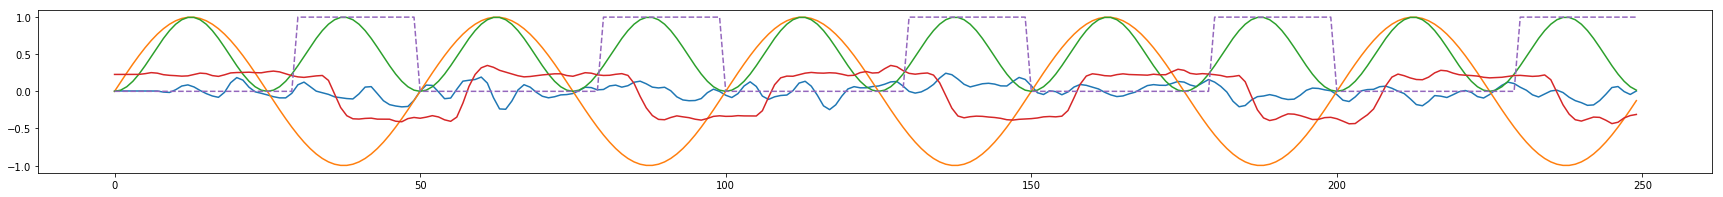

In [4]:
plt.figure(figsize=(30,3))
plt.plot(ts.iloc[:,10])   # ruido
plt.plot(ts.iloc[:,11])   # CSF = seno
plt.plot(ts.iloc[:,12])   # CSF = seno^2
plt.plot(ts.iloc[:,5])    # DMN
plt.plot(task.values[0,:], '--')  #task

**BINARIO O PONDERADO**

La primera prueba que realizada será comprobar el efecto que tiene utilizar distintos umbrales y la pérdida de información que se puede producir al binarizar la matriz de conectividad. Bastará con representarlo sobre el dataset simulado de fMRI:

In [5]:
# Threshold = 0.5
ts_bin_05 = np.matrix(np.copy(real_data))
ts_bin_05[ts_bin_05 < 0.5] = 0
ts_bin_05[ts_bin_05 >= 0.5] = 1
G_05 = nx.from_numpy_matrix(ts_bin_05)
G_05.name = "thr_05" 
G.append(G_05)

# Threshold = 0.3
ts_bin_03 = np.matrix(np.copy(real_data))
ts_bin_03[ts_bin_03 <= 0.3] = 0
ts_bin_03[ts_bin_03 > 0.3] = 1
G_03 = nx.from_numpy_matrix(ts_bin_03)
G_03.name = "thr_03" 
G.append(G_03)

# Threshold = 0.7
ts_bin_07 = np.matrix(np.copy(real_data))
ts_bin_07[ts_bin_07 <= 0.7] = 0
ts_bin_07[ts_bin_07 > 0.7] = 1
G_07 = nx.from_numpy_matrix(ts_bin_07)
G_07.name = "thr_07" 
G.append(G_07)

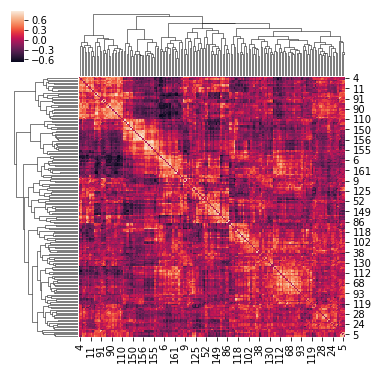

In [6]:
#MATRIZ ORIGINAL
sns.clustermap(real_data, figsize=(6,6))

Y binarizadas resultarían algo como:

Text(0.5,1,'Threshold = 0.7')

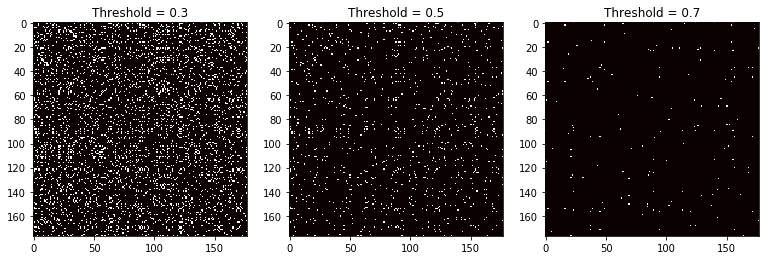

In [7]:
# REPRESENTACION
f = plt.figure(figsize=(13,10))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax1.imshow(ts_bin_03, cmap='hot', interpolation='nearest')
ax1.set_title('Threshold = 0.3')

ax2.imshow(ts_bin_05, cmap='hot', interpolation='nearest')
ax2.set_title('Threshold = 0.5')

ax3.imshow(ts_bin_07, cmap='hot', interpolation='nearest')
ax3.set_title('Threshold = 0.7')

Como se puede observar, conforme se aumenta el umbral, el número de enlaces disminuye y la estructura de la red se ve muy debilitada. Recordemos que los datos de fMRI son tremendamente ruidosos y encontrar correlaciones muy elevadas no es común. 

También podemos representar cómo varía el número de nodos en función del umbral.

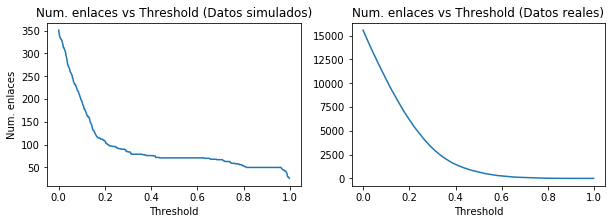

In [8]:
vect = np.arange(500)/500
n_edges_sim = []
n_edges_real = []
xx = np.arange(0, 1, 0.002)

k = 0
for i in vect:
    corr_mat = ts.corr()
    x_sim = corr_mat
    x_sim = abs(x_sim).values
    x_sim[x_sim < i] = 0
    x_sim[x_sim > i] = 1
    Gx_sim = nx.from_numpy_matrix(x_sim)
    n_edges_sim = np.append(n_edges_sim, len(nx.edges(Gx_sim)))
    
    x_real = real_data.copy()
    x_real = abs(x_real).values
    x_real[x_real < i] = 0
    x_real[x_real > i] = 1
    Gx_real = nx.from_numpy_matrix(x_real)
    n_edges_real = np.append(n_edges_real, len(nx.edges(Gx_real)))

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(xx, n_edges_sim)
ax.set_title('Num. enlaces vs Threshold (Datos simulados)')
ax.set_ylabel('Num. enlaces')
ax.set_xlabel('Threshold')

ax2.plot(xx, n_edges_real)
ax2.set_title('Num. enlaces vs Threshold (Datos reales)')
ax2.set_xlabel('Threshold')

plt.savefig('/Users/hose/Desktop/TFM_TECI/simulated_data/thr_vs_lins.png', bbox_inches='tight')

Se puede observar que la relación es no lineal y los datos simulados se asemejan bastante a los datos reales.

Con estos resultados podemos estimar que un umbral límite se sitúa alrededor de 0.4 - 0.5. A partir de ese umbral permanece la información estructural de la red, el número de enlaces varía de forma más lineal con el umbral (lo que quiere decir que es más probable que los enlaces perdidos no sean generados a partir de ruido) y se consigue un valor de correlación elevado que puede tener implicaciones importantes en la red.

No obstante, para estudiar el comportamiento dinámico puede ser no suficiente, ya que no ofrece información sobre la intensidad de la relación ni el signo, algo importante y necesario para entender algunos procesos cognitivos.

**SIGNO DE LA CORRELACIÓN**

La interpretación de la correlación negativa no está aún definida en la literatura de forma clara; ¿son dos procesos que se co-activan de manera inversa o es una simple desconexión funcional aleatoria sin significado? Por ello, es habitual trabajar solo con los valores positivos de correlación. 

A continuación comprobaremos algunos de los efectos tiene trabajar con los valores originales, solo con los positivos, con el valor absoluto o solo con los valores negativos. Para visualizar mejor los efectos, trabajaremos con los datos reales de fMRI:

In [9]:
# Datos originals
real_data.columns = [int(x) for x in real_data.columns]
link_real = hc.linkage(real_data.values, method='centroid')
o1_real = hc.leaves_list(link_real)
mat_real = real_data.iloc[o1_real,:]
mat_real = mat_real.iloc[:, o1_real[::-1]]

# Los valores negativos se ponen a 0
data_pos = np.matrix(np.copy(real_data))
data_pos[data_pos < 0] = 0
link_pos = hc.linkage(data_pos, method='centroid')
o1_pos = hc.leaves_list(link_pos)
mat_pos = data_pos[o1_pos,:]
mat_pos = mat_pos[:, o1_pos[::-1]]

# Se calcula el valor absoluto de cada elemnto de la matriz de conectividad
data_abs = np.matrix(np.copy(real_data))      
data_abs = abs(data_abs)
link_abs = hc.linkage(data_abs, method='centroid')
o1_abs = hc.leaves_list(link_abs)
mat_abs = data_abs[o1_abs,:]
mat_abs = mat_abs[:, o1_abs[::-1]]

# Se trabaja solo con los valores negativos de la matriz
data_neg = np.matrix(np.copy(real_data))      
data_neg[data_neg > 0] = 0   
data_neg = abs(data_neg)
link_neg = hc.linkage(data_neg, method='centroid')
o1_neg = hc.leaves_list(link_neg)
mat_neg = data_neg[o1_neg,:]
mat_neg = mat_neg[:, o1_neg[::-1]]

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


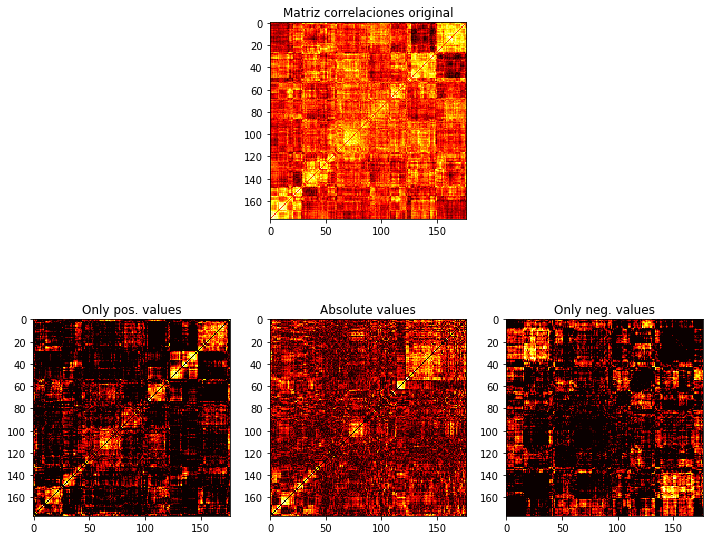

In [10]:
# REPRESENTACION
f = plt.figure(figsize=(12,10))
ax = f.add_subplot(232)
ax2 = f.add_subplot(234)
ax3 = f.add_subplot(235)
ax4 = f.add_subplot(236)

ax.imshow(mat_real, cmap='hot', interpolation='nearest')
ax.set_title('Matriz correlaciones original')

ax2.imshow(mat_pos, cmap='hot', interpolation='nearest')
ax2.set_title('Only pos. values')

ax3.imshow(mat_abs, cmap='hot', interpolation='nearest')
ax3.set_title('Absolute values')

ax4.imshow(mat_neg, cmap='hot', interpolation='nearest')
ax4.set_title('Only neg. values')

plt.savefig('/Users/hose/Desktop/TFM_TECI/simulated_data/sign_weighted.png', bbox_inches='tight')

Como se puede observar, trabajar solo con valores positivos o negativos supone una pérdida considerable de enlaces y, por lo tanto, de información. Si esto se sumase a la binarización de la red con un umbral de 0.5 tendríamos:


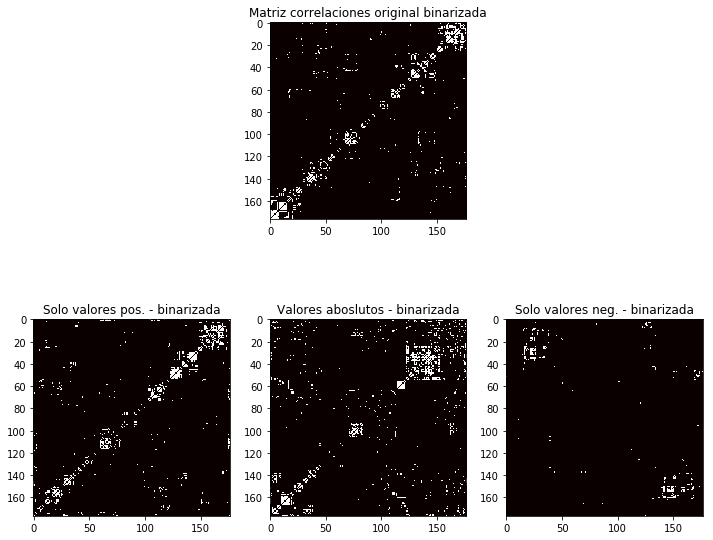

In [11]:
# Threshold = 0.5
mat_real_05 = np.matrix(np.copy(mat_real))
mat_real_05[mat_real_05 < 0.5] = 0
mat_real_05[mat_real_05 >= 0.5] = 1

# Threshold = 0.5
mat_pos_05 = np.matrix(np.copy(mat_pos))
mat_pos_05[mat_pos_05 < 0.5] = 0
mat_pos_05[mat_pos_05 >= 0.5] = 1

# Threshold = 0.5
mat_abs_05 = np.matrix(np.copy(mat_abs))
mat_abs_05[mat_abs_05 < 0.5] = 0
mat_abs_05[mat_abs_05 >= 0.5] = 1

# Threshold = 0.5
mat_neg_05 = np.matrix(np.copy(mat_neg))
mat_neg_05[mat_neg_05 < 0.5] = 0
mat_neg_05[mat_neg_05 >= 0.5] = 1


# REPRESENTACION
f = plt.figure(figsize=(12,10))
ax = f.add_subplot(232)
ax2 = f.add_subplot(234)
ax3 = f.add_subplot(235)
ax4 = f.add_subplot(236)

ax.imshow(mat_real_05, cmap='hot', interpolation='nearest')
ax.set_title('Matriz correlaciones original binarizada')

ax2.imshow(mat_pos_05, cmap='hot', interpolation='nearest')
ax2.set_title('Solo valores pos. - binarizada')

ax3.imshow(mat_abs_05, cmap='hot', interpolation='nearest')
ax3.set_title('Valores aboslutos - binarizada')

ax4.imshow(mat_neg_05, cmap='hot', interpolation='nearest')
ax4.set_title('Solo valores neg. - binarizada')

plt.savefig('/Users/hose/Desktop/TFM_TECI/simulated_data/sign_bin.png', bbox_inches='tight')

El número de enlaces disminuye drásticamente. En una búsqueda exploratoria en la que no se tiene demasiado conocimiento a priori puede suponer un sesgo considerable de los resultados. 

Además, parecen existir estructuras complementarias entre las matrices de valores solo positivos como en la de solo negativos; (vease la relación entre los nodos del 0 al 50 con los del 120 al 160). Parece adecuado mantener el signo de cada estructura con el objetivo de comprender realmente sus relaciones.

**MÉTRICAS**

La matriz de adyacencia o conectividad puede obtenerse a partir de cualquier métrica que sea capaz de capturar aquella información en la que estamos interesados. Dado que la conectividad funcional se define a partir de similitud de la actividad BOLD a lo largo del tiempo, resulta lógico utilizar medidas de correlaciones.

Sin embargo, dada los complejos patrones de actividad cerebral que pueden existir, en este trabajo se propone la distancia de correlaciones como métrica alternativa a la común correlación lineal de Pearson. También se mostrarán los resultados obtenidos a partir de la correlación parcial y de la información mutua (MI).

In [12]:
# Recuerda, dado un conjunto de variables gaussianas Z y siendo X e Y dos variables aleatorias contenidas en Z
# la correlación parcial entre X e Y será 0 si y solo si X es condicionalmente independiente de Y dado Z
"""
Partial Correlation in Python (clone of Matlab's partialcorr)

Extracted from https://gist.github.com/fabianp/9396204419c7b638d38f

This uses the linear regression approach to compute the partial 
correlation (might be slow for a huge number of variables). The 
algorithm is detailed here:
 
    http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression
 
Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
the algorithm can be summarized as
 
    1) perform a normal linear least-squares regression with X as the target and Z as the predictor
    2) calculate the residuals in Step #1
    3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
    4) calculate the residuals in Step #3
    5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 
 
    The result is the partial correlation between X and Y while controlling for the effect of Z
 
 
Date: Nov 2014
Author: Fabian Pedregosa-Izquierdo, f@bianp.net
Testing: Valentina Borghesani, valentinaborghesani@gmail.com
"""
 
import numpy as np
from scipy import stats, linalg
 
def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
 
 
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
 
 
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
     
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot(beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr

In [13]:
## DISTANCE CORRELATION
#(Eq. (2.8) - (2.10) in Székely, Rizzo, and Bakirov, 2007)
# https://projecteuclid.org/euclid.aos/1201012979
def distcorr(X, Y):
    """ Compute the distance correlation function
    
    >>> a = [1,2,3,4,5]
    >>> b = np.array([1,2,9,4,4])
    >>> distcorr(a, b)
    0.762676242417
    """
    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
    
    dcov2_xy = (A * B).sum()/float(n * n)
    dcov2_xx = (A * A).sum()/float(n * n)
    dcov2_yy = (B * B).sum()/float(n * n)
    dcor = np.sqrt(dcov2_xy)/np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))
    return dcor

In [14]:
def plot_corr(df):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(10,10))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
    ax.set_title('Matriz correlaciones clusterizada')

In [15]:
def clustering_mat_corr(df, method, n_clusters):
    
    cluster_th = n_clusters

    if method == 'distcorr':
        for i in range(0,ts.shape[1]):
            for j in range(0,ts.shape[1]):
                dist_corr_mat[i,j] = distcorr(df.values[:,i], df.values[:,j])
        X = dist_corr_mat
    
    else:
        X = df.corr().values
        
    d = sch.distance.pdist(X)
    L = sch.linkage(d, method='complete')
    ind = sch.fcluster(L, 0.5*d.max(), 'distance')

    columns = [df.columns.tolist()[i] for i in list(np.argsort(ind))]
    df = df.reindex_axis(columns, axis=1)

    unique, counts = np.unique(ind, return_counts=True)
    counts = dict(zip(unique, counts))

    i = 0
    j = 0
    columns = []
    for cluster_l1 in set(sorted(ind)):
        j += counts[cluster_l1]
        sub = df[df.columns.values[i:j]]
        if counts[cluster_l1]>cluster_th:        
            X = sub.corr().values
            d = sch.distance.pdist(X)
            L = sch.linkage(d, method='complete')
            ind = sch.fcluster(L, 0.5*d.max(), 'distance')
            col = [sub.columns.tolist()[i] for i in list((np.argsort(ind)))]
            sub = sub.reindex_axis(col, axis=1)
        cols = sub.columns.tolist()
        columns.extend(cols)
        i = j
    df = df.reindex_axis(columns, axis=1)

    plot_corr(df)

In [16]:
# GET CONNECTIVITY MATRIXES 
corr_mat = ts.corr()
dist_corr_mat = np.empty((ts.shape[1],ts.shape[1]))
partial_corr_mat = partial_corr(ts)
MI = np.empty((ts.shape[1], ts.shape[1]))

for i in range(0,ts.shape[1]):
    for j in range(0,ts.shape[1]):
        dist_corr_mat[i,j] = distcorr(ts.values[:,i], ts.values[:,j])
        #cross_corr_mat[i,j] = np.correlate(task.values[:,i], task.values[:,j], 'full')  # https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
        MI[i,j] = normalized_mutual_info_score(ts.values[:,i], ts.values[:,j])

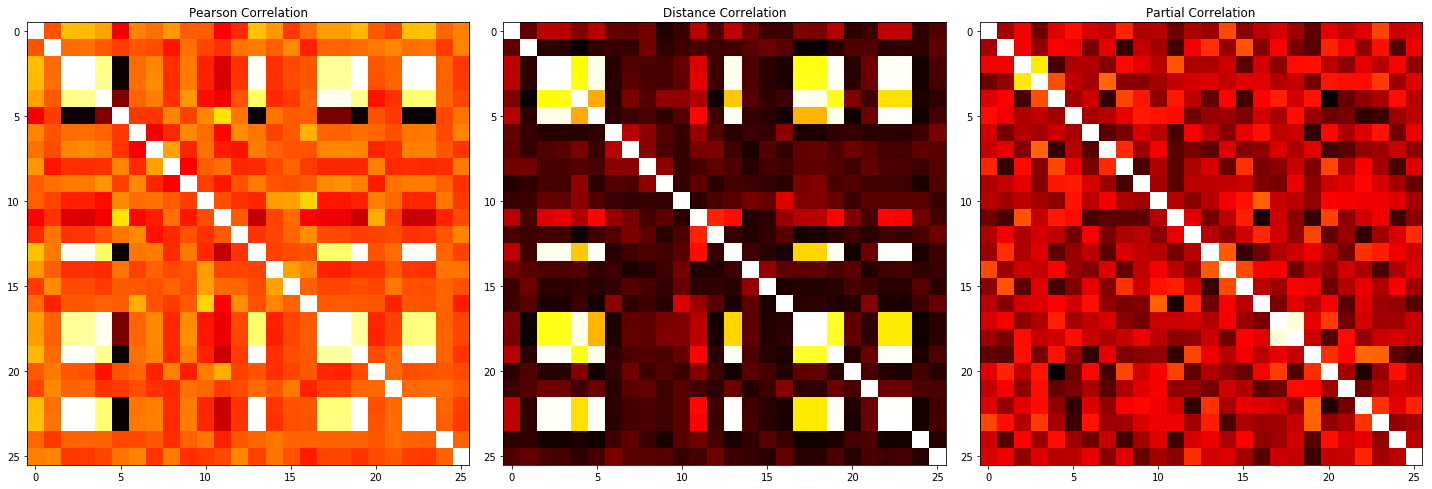

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
im=ax1.imshow(corr_mat, cmap = 'hot')
ax1.set_title('Pearson Correlation')
#f.colorbar(im, ax=ax1)

im=ax2.imshow(dist_corr_mat, cmap = 'hot')
ax2.set_title('Distance Correlation')
#f.colorbar(im, ax=ax2)

im=ax3.imshow(partial_corr_mat, cmap = 'hot')
ax3.set_title('Partial Correlation')
#f.colorbar(im, ax=ax3)

#mi = get_connectivity_matrix(ts, 'MI')
#from sklearn.preprocessing import scale
#normed_mi = scale(mi, axis=0, with_mean=True, with_std=True, copy=True )
#im=ax4.imshow(normed_mi)
#ax4.set_title('Mutual Information')
#fig.colorbar(im, ax=ax4)

f.tight_layout()
plt.savefig('/Users/hose/Desktop/TFM_TECI/simulated_data/metrics.png', bbox_inches='tight')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.


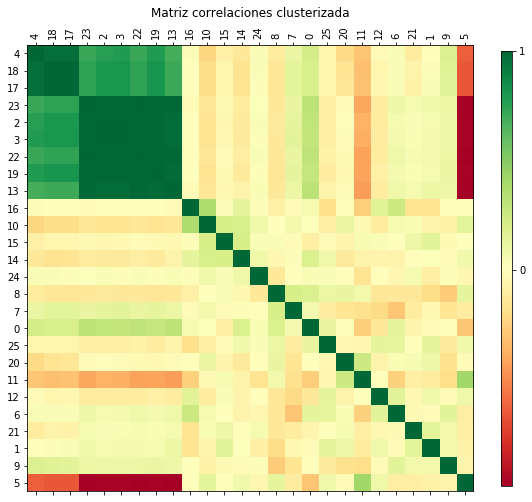

In [18]:
clustering_mat_corr(ts, 'corr', 5)

Como era de esperar, la correlación de pearson detecta todas las fuentes que están altamente correlacionadas entre ellas y con la tarea (ICs 2,3,4,5,13,17,18,19,22 y 23 en las matrices mostradas). De hecho, muestra dos propiedades interesantes: 1) la correlación altamente negativa de la IC 5 (DMN) con las demás y una correlación un poco más débil de las ICs 17 y 18 (componentes motoras que solo se activan cuando se necesita pulsar el botón). También la componente IC 4 tiene una correlación más débil dado que era ruidosa. Con esta información ya se tendrían bastantes pistas sobre el experimento.

Si se analiza la matriz de Distance Correlation se percibe un comportamiento similar, solo que los valores parecen más extremos ya que el rango solo va de [0,1]. Esto produce que la correlacion de la DMN (IC 5) aparezca bastante alta pero no ofrezca información sobre su signo; simplemente indica que existe una fuerte asociación. Otro aspecto reseñable es la detección levemente superior de correlación entre las componentes de CSF (ICs 11 y 12) que introdujimos al comienzo de este anexo. La IC12 = IC11 * IC11. Lamentablemente, la visualización enmascara esta capacidad frente a la matriz de correlación de Pearson, pero si observamos sus valores analíticos tenemos que:

In [19]:
distcorr(ts.iloc[:,11], ts.iloc[:,12])

0.4487637002910036

In [20]:
pearsonr(ts.iloc[:,11], ts.iloc[:,12])

(-1.2079226507921704e-16, 1.0)

En cuanto a la correlación parcial, la explicación de porqué no aparece nada correlacionado es sencilla. Dadas dos variables aleatorias A y B pertenecientes a un conjunto M, la correlación parcial realiza un modelo de regresión donde "elimina" toda la información que hay en común en B y el resto del conjunto M (sin A) y lo mismo realiza con A. Así, la correlación se realiza sobre los residuos de los dos modelos lineales.

En este caso, la información que hay contenida en cada una de las variables correlacionadas es prácticamente la misma. Así, al realizar la correlación parcial entre, por ejemplo, las componentes 2 y 3, el residuo que se obtiene al "regresar" la información de las componentes 4,5,13,17,18,19,22 y 23 es prácticamente nula, por lo que no existe correlación parcial.

De hecho, existe un pequeño grupo que corresponde a las componentes motoras 17 y 18, que solo se activaban en condiciones especiales, lo que conlleva que el resto de la matriz no contenga esa información. Esto implica que la correlación parcial sea utilizada solo bajo situaciones donde se conozcan realmente bien los datos y pueda decidirse qué elementos regresar y cuáles no para evitar tener una red no conexa.

En cuanto a la distancia de correlaciones y la correlación de Pearson, a partir de los datos simulados, preferimos trabajar con la correlación de Pearson normal. A pesar de detectar las relaciones no lineales, la fuerza de la asociación sigue siendo débil o dificil de detectar frente al ruido o relaciones poco significativas. Además, no ofrece ofrece información sobre el signo de la asociación, algo que puede ser de relevancia y sí ofrece la correlación de Pearson (a un coste computacional inferior).

**SLIDING WINDOW**

En este apartado se estudiarán dos aspectos: el solapamiento entre ventanas y el tamaño de cada ventana temporal. Estas pruebas están orientadas a la búsqueda de conectividad funcional dinámica, por lo que definir una correcta escala de tiempos se hace imprescindible.

El procedimiento es el siguiente:
- A partir de las series temporales de cada región, se generarán distintas capas temporales a partir del tamaño de venta w y el solapamiento entre ventanas.
- Para cada una de estas matrices o capas temporales de duración w, se construirá la matriz de conectividad. Las matrices de conectividad se generan a partir de modelos lineales sin intercepto, de donde extraeremos el peso del enlace (coeficiente de determinación = coeficiente de correlacion de Pearson^2) y el p-valor de cada enlace, que permitirá discernir cuántos puntos temporales pueden ser suficientes para tener un tamaño de ventana adecuado.


In [21]:
def gen_sliding_window(ROI_timeseries, w, overlapping):
    # For a simple timeserie
    if len(ROI_timeseries)==1:
        n_windows = int((ROI_timeseries.shape[1]-w)/(w*(1-overlapping)))
        sliding_windows = np.zeros((n_windows,w))
        sliding_windows[0,:] = ROI_timeseries.values[0,0:w]
        for i in range(1, n_windows):
            inc = int(i*w*(1-overlapping))
            sliding_windows[i,:] = ROI_timeseries.values[0,inc:inc+w]
    
    # For a matrix of timeseries
    # Create the different sliding-windows for a given subject
    else:
        n_windows = int((ROI_timeseries.shape[0]-w)/(w*(1-overlapping)))
        sliding_windows = np.zeros((w, ROI_timeseries.shape[1], n_windows))
        for j in range(0,ts.shape[1]):
            sliding_windows[:,j,0] = ROI_timeseries.iloc[:,j].values[0:w]
            for i in range(1,n_windows):
                inc = int(i*w*(1-overlapping))
                sliding_windows[:,j,i] = ROI_timeseries.iloc[:,j].values[inc:inc+w]
    
    return sliding_windows

In [22]:
# Funcion para calcular la correlación entre 2 matrices
def correlation_coefficient(T1, T2):
    numerator = np.mean((T1 - T1.mean()) * (T2 - T2.mean()))
    denominator = T1.std() * T2.std()
    if denominator == 0:
        return 0
    else:
        result = numerator / denominator
        return result

In [23]:
# Construcción de la matriz de conectividad a partir de las métricas vistas en el apartado anterior
def get_connectivity_matrix(sliding_window, metric_rule):
    if metric_rule == 'corr':
        conn_mat = sliding_window.corr()
        
    elif metric_rule == 'partial_corr':
        conn_mat = partial_corr(sliding_window.values)
        
    elif metric_rule == 'distance_corr':
        conn_mat = np.empty((sliding_window.shape[1],sliding_window.shape[1]))
        for i in range(0,sliding_window.shape[1]):
            for j in range(0,sliding_window.shape[1]):
                conn_mat[i,j] = distcorr(sliding_window.values[:,i], sliding_window.values[:,j])
    
    elif metric_rule == 'MI':
        conn_mat = np.empty((sliding_window.shape[1],sliding_window.shape[1]))
        for i in range(0,sliding_window.shape[1]):
            for j in range(0,sliding_window.shape[1]):
                conn_mat[i,j] = normalized_mutual_info_score(sliding_window.values[:,i], sliding_window.values[:,j])
    
    return conn_mat

In [24]:
# Generación de la matriz de conectividad con el modelo lineal
def get_sliding_conn_mat(slide_w_matrix, w, overlapping):
    n_windows = slide_w_matrix.shape[2]
    conn_mat = np.zeros((slide_w_matrix.shape[1], slide_w_matrix.shape[1], n_windows))
    p_mat = np.zeros((slide_w_matrix.shape[1], slide_w_matrix.shape[1], n_windows))
    x_lim = conn_mat.shape[0]-1
    for l in range(0, conn_mat.shape[2]):  # num. of layers
        for i in range(0, (conn_mat.shape[0])):
            for j in range(0, (conn_mat.shape[0])):
                # Note the result is R^2, not r like en Pearson correlations!
                conn_mat[i,j,l] = linregress(slide_w_matrix[:,i,l], slide_w_matrix[:,j,l])[2] #get_connectivity_matrix(slide_w_matrix, 'distance_corr')
                p_mat[i,j,l] = linregress(slide_w_matrix[:,i,l], slide_w_matrix[:,j,l])[3]

    return conn_mat, p_mat

In [25]:
# Función para pintar las matrices de correlaciones en forma de matriz y fila a fila como una serie temporal
def plot_matrix_correlation(matrix_correlation, w, overlapping):
    output_path = '/Users/hose/Desktop/TFM_TECI/simulated_data/sliding_windows/'
    fig1 = plt.imshow(matrix_correlation)
    namefig = output_path + 'Matrix_correlation' + str(w) + '_' + str(overlapping) + '.svg'
    plt.savefig(namefig, dpi=None, facecolor='w', edgecolor='w', orientation='landscape', 
            papertype='a4', format='svg', transparent=True, bbox_inches='tight', 
            pad_inches=0.1, frameon=None)
    plt.close()
    
    fig2, axes = plt.subplots(nrows=5, ncols=5, figsize=(24,15))
    i=0
    for ax in axes.flat:
        if i<24:
            im = ax.plot(matrix_correlation[i,:])
            ax.title.set_text('Correlaciones de la ventana %i' %i)
            i=i+1
    
    return fig1

In [26]:
# Función para visualizar las matrices de conectividad de cada ventana temporal a modo de heatmap
def plot_sliding_window(conn_mat, w, overlapping):
    output_path = '/Users/hose/Desktop/TFM_TECI/simulated_data/sliding_windows/'
    n_windows = conn_mat.shape[2]
    if conn_mat.shape[2]>8:
        n_cols = 8
    else:
        n_cols = conn_mat.shape[2]
    n_rows = round(n_windows/n_cols)
    if n_rows*n_cols < conn_mat.shape[2]:
        n_rows = n_rows + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))
    i = 0
    start = 0
    end = start + w

    for ax in axes.flat:
        if i<n_windows:
            im = ax.imshow(conn_mat[:,:,i], interpolation='nearest')
            plt.xticks(np.arange(0,conn_mat.shape[0],2))
            plt.yticks(np.arange(0,conn_mat.shape[0],2))
            ax.title.set_text('From %i to %i seg.' %(start,end))
            i=i+1
            start = end - w*overlapping
            end = start + w

    fig.subplots_adjust(bottom=0.01, top=0.9, left=0.01, right=0.75, wspace=0.1, hspace=0.1)
    cb_ax = fig.add_axes([0.76, 0.1, 0.02, 0.6])
    cbar = fig.colorbar(im, cax=cb_ax)

    output_name = output_path + 'sw_conn_' + str(w) + '_' + str(overlapping) + '.svg'
    plt.savefig(output_name, 
            dpi=None, facecolor='w', edgecolor='w', orientation='landscape', 
            papertype='a4', format='svg', transparent=True, bbox_inches='tight', 
            pad_inches=0.1, frameon=None)
    plt.close()

In [27]:
def plot_nodes_of_interest(slide_conn_matrix, nodes_of_interest, w, overlapping):
    output_path = '/Users/hose/Desktop/TFM_TECI/simulated_data/sliding_windows/'
    if len(nodes_of_interest)<4:
        ncols=len(nodes_of_interest)
    else:
        n_cols = 4
    n_rows = round(len(nodes_of_interest)/n_cols)  # numero de nodos
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3.5*n_cols, 3*n_rows))
    i=0
    for ax in axes.flat:
        im = ax.plot(slide_conn_matrix[nodes_of_interest[i][0],nodes_of_interest[i][1],:])   # Connectivity along time between nodes
        ax.title.set_text('Nodes %i - %i' %(nodes_of_interest[i][0],nodes_of_interest[i][1]))
        ax.set_xlabel('Time (n_window)')
        if i==0:
            ax.set_ylabel('Connectivity')
        i = i +1

    output_name = output_path + 'nodes_of_interest_' + str(w) + '_' + str(overlapping) + '.svg'
    plt.savefig(output_name, 
            dpi=None, facecolor='w', edgecolor='w', orientation='landscape', 
            papertype='a4', format='svg', transparent=True, bbox_inches='tight', 
            pad_inches=0.1, frameon=None)
    plt.close()  # No mostrar en el jupyter

In [28]:
def plot_temporal_corr(conn_mat, w, overlapping, n_windows, node_of_interest):
    output_path = '/Users/hose/Desktop/TFM_TECI/simulated_data/sliding_windows/'
    n_cols = 4
    n_rows = round(len(node_of_interest)/n_cols)  # numero de nodos
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 3*n_rows))
    i = 0  # contador para las ventanas temporales

    for ax in axes.flat:
        if i<n_windows:
            x = np.array(conn_mat[node_of_interest[i][0],node_of_interest[i][1],:])
            #im = ax.plot(task_design, 'r--', linewidth = 0.75)        # Diseño por bloques de la tarea
            im = ax.plot(x, linewidth = 2)                            # Correlacion entre nodos (i,j) a lo largo de las capas temporales (evolución o sincronía)
            #level_corr = round(np.corrcoef(task_design, x)[0][1],2)   # Redonde al 2º decimal
            #txxt = 'Corr_with_task=' + str(level_corr)
            #ax.text(-0.97,-0.97, txxt, ha='left', fontsize=10)
            ax.title.set_text('Corr. of nodes %i - %i seg.' %(node_of_interest[i][0],node_of_interest[i][1]))
            ax.set_xlabel('n_window')
            ax.set_ylabel('Coef. corr Pearson')
            i=i+1
    
    # Exporta la figura
    output_name = output_path + 'corr_evol_' + str(w) + '_' + str(overlapping) + '.svg'
    plt.savefig(output_name, 
            dpi=None, facecolor='w', edgecolor='w', orientation='landscape', 
            papertype='a4', format='svg', transparent=True, bbox_inches='tight', 
            pad_inches=0.1, frameon=None)
    plt.close()  # No mostrar en el jupyter

In [29]:
def plot_allcases(all_cases, w, overlapping):
    n = len(all_cases)
    n_cols = len(overlapping)
    n_rows = int(n/n_cols)
    output_path = '/Users/hose/Desktop/TFM_TECI/simulated_data/sliding_windows/'
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3.3*n_rows))
    i = 0
    ov_pos = 0
    for ax in axes.flat:
        im = ax.imshow(all_cases[i]) 
        w_pos = int(i/len(overlapping))
        if ov_pos==len(overlapping):
            ov_pos = 0
        ax.title.set_text('W = %i  Overl. = %i percent ' %(w[w_pos], overlapping[ov_pos]*100))
        i=i+1
        ov_pos = ov_pos + 1

    cb_ax = fig.add_axes([1, 0.1, 0.02, 0.6])
    cbar = fig.colorbar(im, cax=cb_ax)
    fig.suptitle('Correlación entre ventanas temporales', fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    # Exporta la figura
    output_name = output_path + 'conn_avg.svg'
    plt.savefig(output_name, 
            dpi=None, facecolor='w', edgecolor='w', orientation='landscape', 
            papertype='a4', format='svg', transparent=True, bbox_inches='tight', 
            pad_inches=0.1, frameon=None)
    #plt.close()  # No mostrar en el jupyter

La siguiente función se utiliza para estudiar la evolución que existe en la conectividad funcional entre dos nodos. Esta evolución va a depender de:
    - La métrica con la que se haya construido la matriz de conectividad *conn_mat*
    - El tamaño de ventana *w*
    - El *overlapping* entre ventanas

Es necesario introducir las parejas de nodos de interés que queremos estudiar (la combinatoria posible es enorme). 
Por último, en cada plot se añade el diseño de la tarea por bloques para asociar a qué parte del experimento corresponde cada parte de la evolución.
    

Así, tan solo queda definir un conjunto de tamaños de ventana, de proporciones de overlapping:

In [30]:
w = np.array([10,20,30,40,50])
overlapping = np.array([0.2, 0.4, 0.6, 0.8])
p_median = np.zeros([len(w), len(overlapping)])
all_cases = []
node_of_interest = node_of_interest_sim
#task_w = gen_sliding_window(task, w, overlapping)   

for i in range(0,len(w)):
    for j in range(0,len(overlapping)):
        n_windows = int((ts.shape[0]-w[i])/(w[i]*overlapping[j]))                                                # Calculamos el numero de ventanas para esta combinacio
        slide_w_matrix = gen_sliding_window(ts, w[i], overlapping[j])                                            # Generamos el tensor 3D con las múltiples ventanas temporales
        slide_conn_matrix, slide_p_matrix = get_sliding_conn_mat(slide_w_matrix, w[i], overlapping[j])  # Calculamos la matriz de conectividad para cada capa temporal (a partir de un modelo lineal)
        plot_nodes_of_interest(slide_conn_matrix, node_of_interest, w[i], overlapping[j])
        matrix_correlation = np.zeros([slide_conn_matrix.shape[2],slide_conn_matrix.shape[2]])
        for k in range(0,slide_conn_matrix.shape[2]):                                                              # Cálculo de la correlación entre 2 matrices.
            for m in range(0,slide_conn_matrix.shape[2]):                                                          # El resultado es otra matriz, donde la celda (i,j) es la correlación entre las matrices de las ventanas i,j
                matrix_correlation[k,m] = correlation_coefficient(slide_conn_matrix[:,:,k], slide_conn_matrix[:,:,m])
        all_cases.append(matrix_correlation)
        #plot_matrix_correlation(matrix_correlation, w[i], overlapping[j])
        p_median[i,j] = np.median(slide_p_matrix)                                            # Extraemos la mediana de cada matriz de p-valores como medida orientativa sobre significancia
        plot_sliding_window(slide_conn_matrix, w[i], overlapping[j])                                    # Pintamos las matrices de connectividad para cada ventana
        plot_temporal_corr(slide_conn_matrix, w[i], overlapping[j], n_windows, node_of_interest)     # Y la evolucion de la correlacion entre cada par de nodos de interes

Las figuras que se generan son exportadas automáticamente. En cualquier momento se pueden volver a cargar y visualizarlas. Todas las figuras estarán adjuntas junto a este código en el material complementario de la memoria. Pasemos a analizar los resultados poco a poco.

Lo primero, recordemos el aspecto que tenían las matrices de conectividad globales:

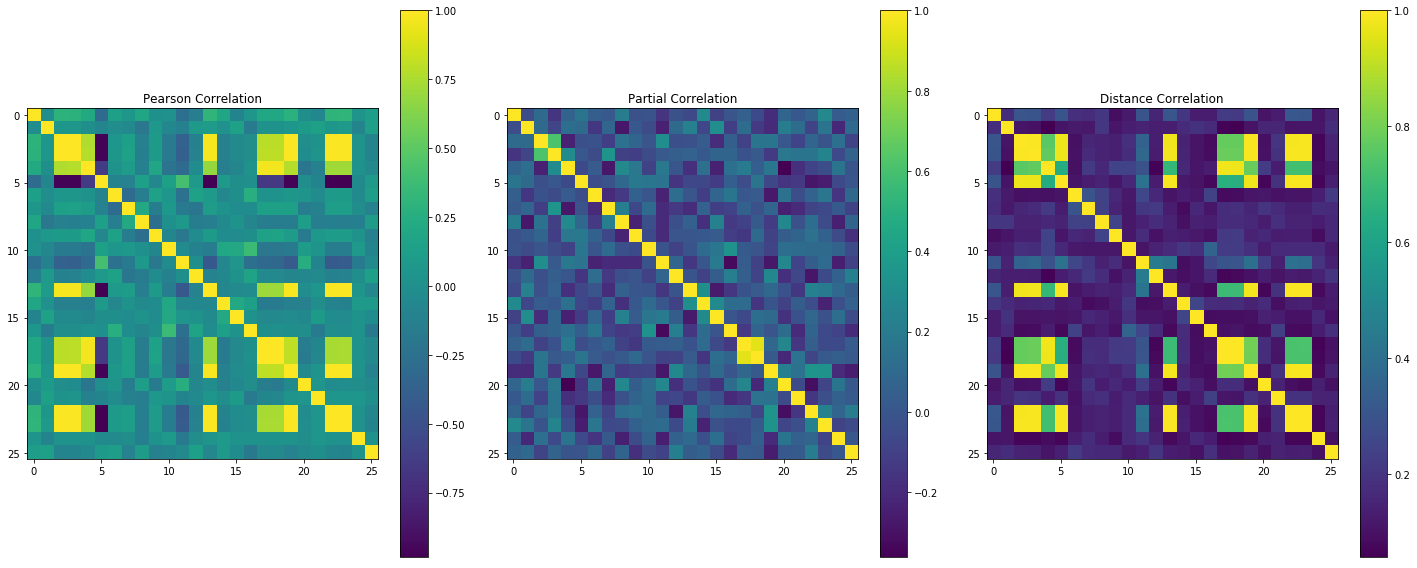

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))
im=ax1.imshow(get_connectivity_matrix(ts, 'corr'))
ax1.set_title('Pearson Correlation')
fig.colorbar(im, ax=ax1)

im=ax2.imshow(get_connectivity_matrix(ts, 'partial_corr'))
ax2.set_title('Partial Correlation')
fig.colorbar(im, ax=ax2)

im=ax3.imshow(get_connectivity_matrix(ts, 'distance_corr'))
ax3.set_title('Distance Correlation')
fig.colorbar(im, ax=ax3)

#mi = get_connectivity_matrix(ts, 'MI')
#from sklearn.preprocessing import scale
#normed_mi = scale(mi, axis=0, with_mean=True, with_std=True, copy=True )
#im=ax4.imshow(normed_mi)
#ax4.set_title('Mutual Information')
#fig.colorbar(im, ax=ax4)

fig.tight_layout()

No obstante, promediar conlleva eliminar variabilidad y, por lo tanto, información dinámica. Para comprobar qué configuración es capaz de detectar mejor el paradigma ON-OFF de nuestra simulación, será necesario repasar cuidadosamente la evolución temporal de cada configuración. Los archivos con nombre *sw_conn_wXX_overlapXX.svg* reflejan tales cambios para cada configuración. Para evitar que este anexo quede excesivamente largo, se mostrará la mejor opción para cada tamaño de ventana con el objetivo de comparar los resultados.

A modo de ayuda, a continuación se muestra también el diseño de tareas por bloque y el comportamiento temporal de las ICs asociadas con ellas.

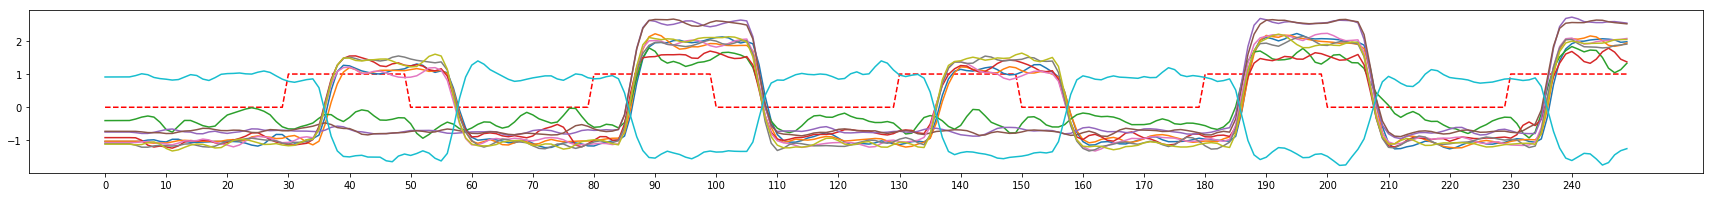

In [33]:
def plot_task_series():
    plt.figure(figsize=(30,3))
    plt.plot(task.values[0,:], 'r--')
    plt.plot(4*ts.values[:,2])
    plt.plot(4*ts.values[:,3])
    plt.plot(4*ts.values[:,4])
    plt.plot(4*ts.values[:,13])
    plt.plot(4*ts.values[:,17])    #MOTOR
    plt.plot(4*ts.values[:,18])    #MOTOR
    plt.plot(4*ts.values[:,19])     
    plt.plot(4*ts.values[:,22])     #AUD
    plt.plot(4*ts.values[:,23])     #AUD
    plt.plot(4*ts.values[:,5])      #DMN
    plt.xticks(np.arange(0,task.shape[1],10))
    plt.show()

plot_task_series()

Resumen de la actividad: 

    a) Existen varios nodos fuertemente correlacionados.
    b) Existen 2 tipos diferentes de activación ON: cuando hay activación motora (pulsos 2,4 y 4), con mayor correlación....y 2 pulsos sin activación motora (1 y 3) y correlación más débil.
    c) El nodo 5 (DMN) está correlacionado negativamente.
    d) Existen dos nodos (CSF) donde uno es el cuadrado de otro (no mostrado en el plot anterior)

**W=10 y overlapping=0.2**

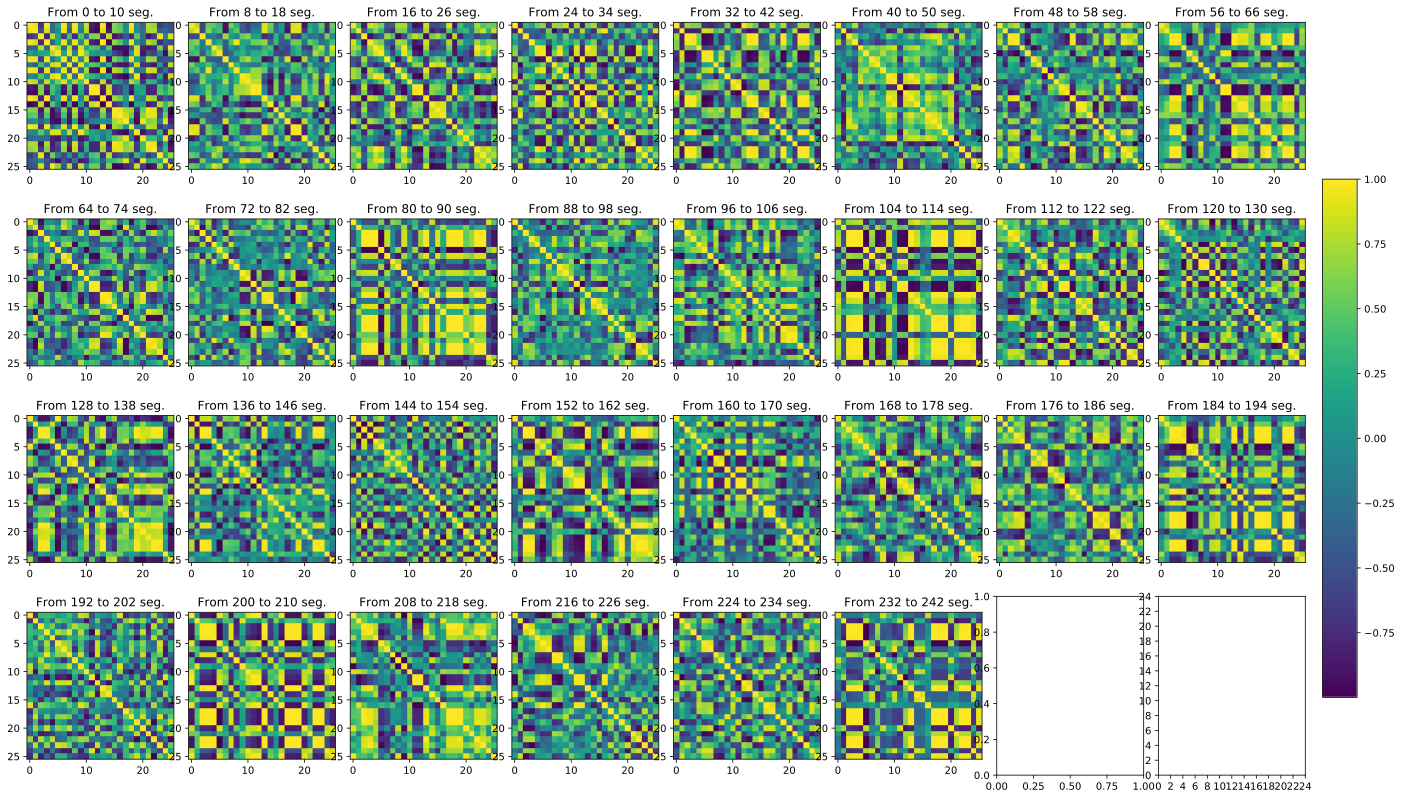

In [34]:
from IPython.display import SVG
SVG('/Users/hose/Desktop/TFM_TECI/simulated_data/sliding_windows/sw_conn_10_0.2.svg')

Este tamaño de ventana es capaz de captar de forma considerable las transiciones entre ON-OFF (véase OFF-ON en *From 80 to 90 seg* o ON-OFF en *From 104 to 114 seg.*). Cuanto mayor sea el overlapping, la transición aparecerá en un mayor número de ventanas seguidas. Sin embargo, al ser la ventana temporal tan corta, tiene menos fiabilidad la estimación; no se distinguen los estados de ON-OFF (solo las transiciones) y existe un mayor número de componentes que aparecen como fuertemente relacionadas cuando realmente solo son ruido (véase *From 104 to 114* ó *From 144 to 154 seg.*).

Los resultados son similares aunque se aumente el tamaño de overlapping. Aquí el mayor problema es que el tamaño de la ventana es demasiado pequeño.

**W=20 y overlapping=0.8**

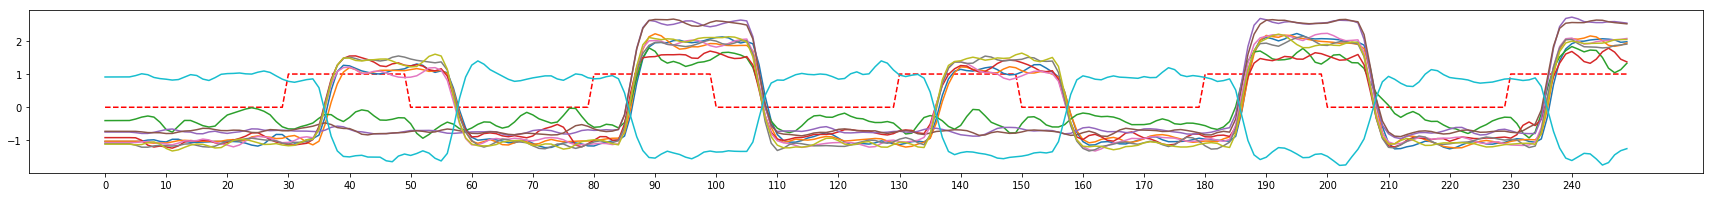

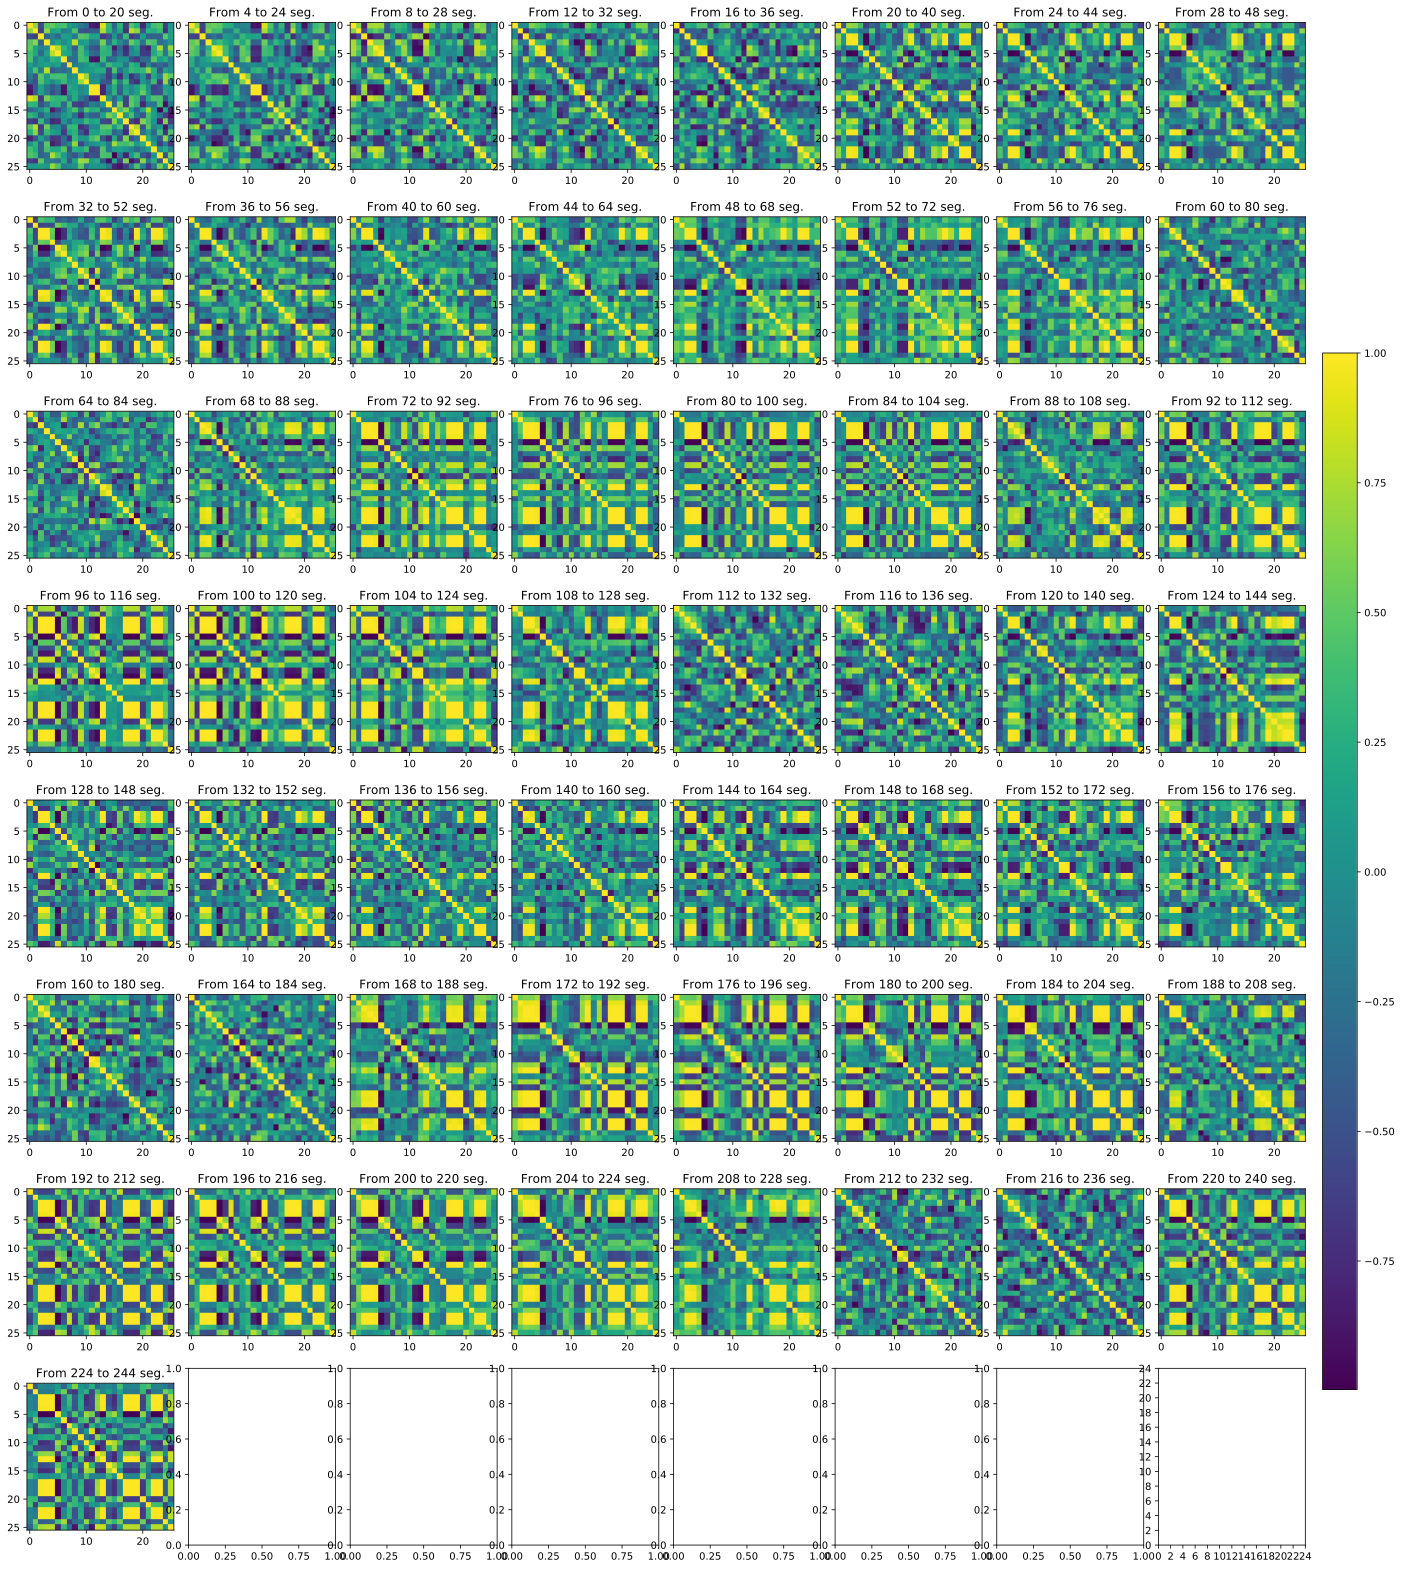

In [35]:
plot_task_series()
SVG('/Users/hose/Desktop/TFM_TECI/simulated_data/sliding_windows/sw_conn_20_0.8.svg')

En este caso, el tamaño de ventana coincide con el tiempo que la tarea permanece en ON (sin contar el período de transición). Gracias a esto, sí que es posible detectar diferencias evidentes entre los estados de ON y OFF. Sin embargo, a simple vista podría parecer que la duración de ON es mucho mayor que la de OFF. Esto se debe a que las transiciones comunes que tienen los nodos activas hace que las correlaciones sean considerables y pudiendo confundirse con el estado de ON.

No obstante, existe un patrón que permite detectar con buena aproximación cuándo comienza cada estado. 1) Siempre existen 2-3 matrices completamente dispersas entre estados de activación (véase por ejemplo *From 212 to 232 seg-* y *From 216 to 236 seg.*) y 2) la matriz de conectividad se afina en los estados de ON respecto de las ventanas de transición, esto es, los nodos de interés aumentan su correlación y la correlación entre el resto de nodos ruidosos disminuye, como si alcanzase un máximo desde el que comienza a bajar cuando vuelve a contener la transición de bajada (ON-OFF) en la bajada. 

Gracias a estas matrices dispersas entre activaciones se puede definir con precisión en qué instante comienza y termina cada período. La transición de OFF-ON se dará alrededor del instante final de la última matriz dispersa previa a la activación (por ejemplo, en *From 64 to 84 seg.*, se puede decir que la activación ocurre próxima a 84) y la transición de ON-OFF vendrá dado por el instante inicial de la primera ventana dispersa tras el período ON ( en *From 112 to 132 seg.*, el período de OFF comenzará en 112 seg. aprox.).

Véase por ejemplo el proceso desde *From 168 to 188 seg.*, donde comienza a capturar la transición de OFF-ON, llegando a su máximo en *From 184 to 204 seg.* y disminuyendo en la siguiente ventana *From 188 to 208 seg.* porque vuelve a capturar la transición entre estados, en este caso de ON-OFF.

De hecho, este nivel de correlación respecto del fondo ruidoso es lo que permite a su vez detectar dos posibles estados de activación: cuando existe actividad motora o no. Compárense las matrices de conectividad cuando no hay actividad motora (correlaciones menores) de *From 120 to 140 seg.* a *From 156 to 176 seg.* con la activación motora (siguiente estado en ON) de *From 168 to 188 seg.* a *From 208 to 228 seg.*

Estas propiedades se han encontrado también para solapamientos de W=20, pero con overlapping = 0.8 se puede detectar mejor esta transición y las 2 matrices de estado OFF que hay entre cada estado de ON se mantienen más evidentes que con los otros solapamientos.


**W=30 y overlapping=0.8**

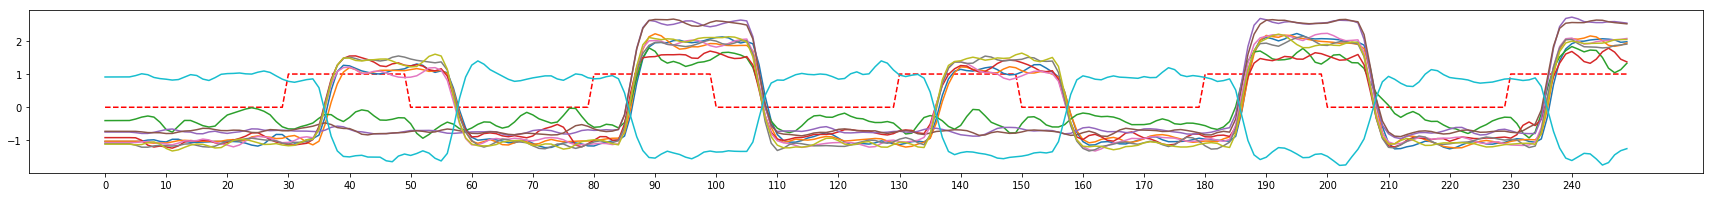

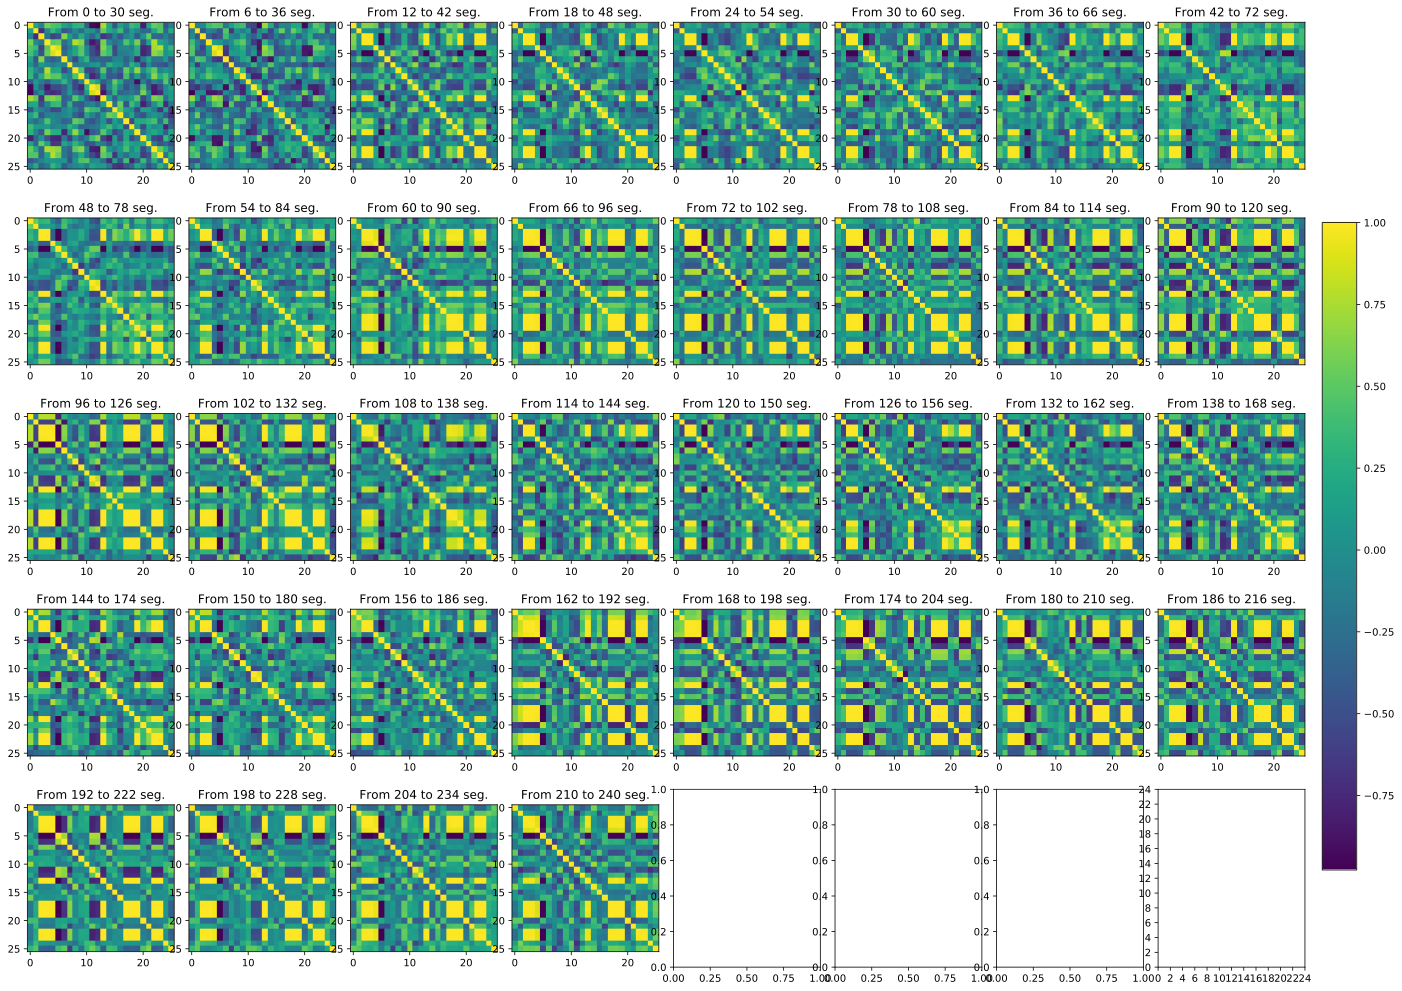

In [36]:
plot_task_series()
SVG('/Users/hose/Desktop/TFM_TECI/simulated_data/sliding_windows/sw_conn_30_0.8.svg')

En este punto empieza a notarse uno de los problemas que se verán acentuados con ventanas más grandes; dado que las ventanas son más largas que el estado de ON, existen solapamientos entre estados, lo que hace que siempre tengamos una matriz conectada en todas las ventanas y sea difícil detectar ON-OFF (no existe transición de matrices dispersas como con W=20). No obstante, con W=30 aún se puede parametrizar el solapamiento (cuanto mayor solapamiento, más gradual será el avance temporal y los cambios detectados) de forma que pueda intuirse cuándo son los cambios de estado.

Véase por ejemplo el cambio que existe entre la ventana *From 180 to 210 seg.*, que coincide justamente con el estado ON, respecto de las ventanas anteriores y posteriores a ella. La matriz de conectividad refleja de manera mucho más limpia la conectividad que existe entre los nodos de interés, mientras que entre el resto de nodos se mantiene más dispersa. También existe un cambio importante en la intesidad de las correlaciones respecto del estado OFF a la transición entre OFF-ON.

**W=40 y overlapping=0.4**

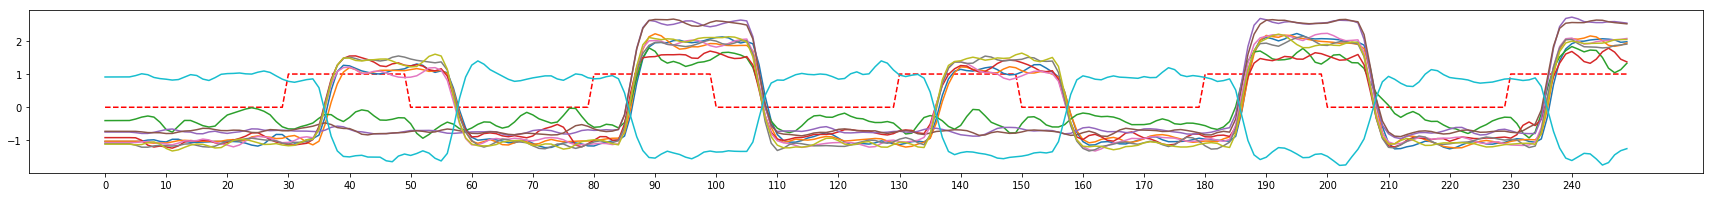

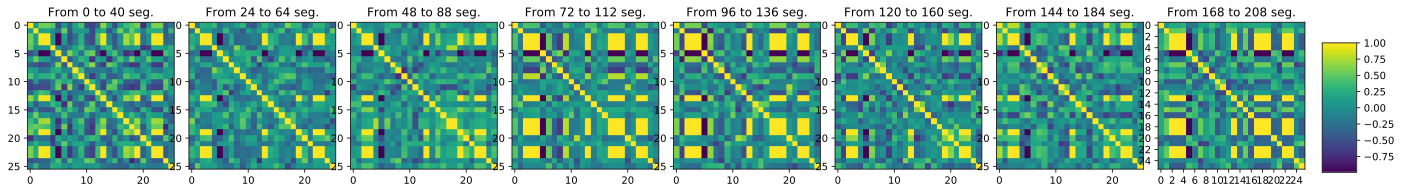

In [37]:
plot_task_series()
SVG('/Users/hose/Desktop/TFM_TECI/simulated_data/sliding_windows/sw_conn_40_0.4.svg')

**W=50 y overlapping=0.4**

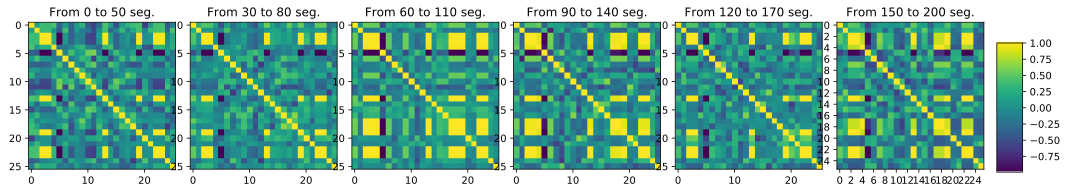

In [38]:
SVG('/Users/hose/Desktop/TFM_TECI/simulated_data/sliding_windows/sw_conn_50_0.4.svg')

Como se comentaba en W=30, las ventanas se hacen tan grandes respecto de la duración de cada estado que siempre capturan períodos de transición o activación, por lo que los nodos de interés aparecen siempre correlacionados y. Cuanto mayor sea W, más complicado será definir en qué estado se encuentra la red.

Con todo esto, se concluye que un un tamaño de ventana aceptable estaría entre 20 y 30 seg. Es decir, el tamaño de ventana vendrá dado por la actividad que se desee capturar. Si se desconoce esta información es muy probable que la ventana utilizada sea incapaz de capturar toda la información. En este punto podría ser útil utilizar técnicas con tamaño variable de ventana como las wavelets.

El overlapping permite detectar cambios y transiciones graduales en la red. Aunque esto puede ayudar a definir mejor cada estado, existen situaciones en las que vuelve los resultados más difusos por no encontrar variaciones definidas. Es importante balancear el tamaño de ventana con un overlapping acorde.

**Así, concluimos que la configuración que mejor resultado ofrece de todas las que se han probado es W=20 y overlapping = 0.8**



Para terminar, podemos representar la correlación que existe entre las capas temporales de cada configuración. Esto es, la correlación de la ventana t con t+1. Con esta representación se pretende detectar el comportamiento periódico que existe en la tarea de activación. Es decir, si las ventanas de t=4 a t=10 representan en el período de activacón, deberán estar correlacionadas con aquellas ventanas que representen el siguiente período de activación pero no con las ventanas del período de reposo.

Ese ha sido el cálculo obtenido con la función *correlation coefficient* del cuadro de código anterior. El objetivo es identificar distintos estados de la red (por ejemplo, ON-OFF), lo que resultaría posible si el tamaño de ventana es adecuado.

In [ ]:
plot_allcases(all_cases, w, overlapping)    # Correlación entre ventanas temporales

Conclusiones similares a las anteriores son las que pueden extraerse:

    - Parece que el período en ON es mayor que el de OFF debido a que las transiciones también producen correlaciones altas.
    - Cuanto mayor es la ventana W, menos diferencia se captura ente ON-OFF.
    - Si la ventana W es demasiado pequeña, cuando está se encuentre en mitad del período en ON solo se detectará una actividad constante y no habrá distinción entre los nodos de interés y el resto de nodos ruidosos de la red (vease cómo aparece una columna en medio de correlación mínima en cada período ON).
    - La configuración más robusta es la de W = 20.
    - El overlapping ayuda considerablemente a definir con mayor precisión las transiciones. Cuanto mayor es W, más importante se hace este parámetro.


Para concluir, nótese que en este estudio se conocía el estado real de la red, por lo que hemos podido estudiar cuál era la configuración que más se ajustaba a ello. ¿Qué ocurriría si no se conociese ese ground truth? Y si apareciesen patrones con dos configuraciones totalmente diferentes, ¿cómo se podría saber si son relevantes o fruto del ruido? Como se adelantaba en la memoria, sería adecuado desarrollar un método no supervisado que tuviese en cuenta todas estas situaciones.

En la plataforma diseñada por el autor de este trabajo a la que se referencia en la memoria se proponía un clustering difuso con un conjunto de reglas de inspiración biológica en este sentido: utilizar la información estructural del DTI, recursos de atlas funcionales o sistemas basados en reputación son algunas de las opciones. 

Como último experimento de este anexo, podemos desarrollar una medida ponderada que reproduzca algo similar a un sistema de reputación. La idea es sencilla: dado que los datos son ruidosos, podemos otorgar "votos de confianza" a aquellos nodos que suelen mostrar un determinado patrón de forma que su ponderación sea mucho más alta a la hora de generar las correlaciones entre las matrices de conectividad a lo largo del tiempo. La forma más inmediata es colocar un umbral a partir del cual consideramos que la correlación es fruto del ruido y las ponemos a 0. Así, las correlaciones de aquellas regiones co-activadas no se verán enmascaradas por efecto del ruido.